_Last Updated: 04/08/2021_

In [1]:
import gurobipy as gp
from gurobipy import GRB, abs_
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from graphviz import Digraph, Graph
%matplotlib inline

# Bender's Decomposition

### Two-Layer Basic MIP Formulation

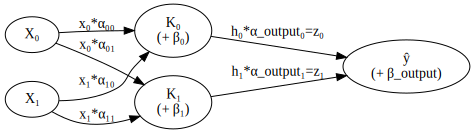

In [2]:
SUB = str.maketrans("0123456789mn", "₀₁₂₃₄₅₆₇₈₉ₘₙ")

g = Digraph()
g = Digraph(graph_attr={'rankdir':'LR'})
g.edge("X0".translate(SUB), "K0 \n (+ β0)".translate(SUB), label = "x0*α00".translate(SUB))
g.edge("X0".translate(SUB), "K1 \n (+ β1)".translate(SUB), label = "x0*α01".translate(SUB))
g.edge("X1".translate(SUB), "K0 \n (+ β0)".translate(SUB), label = "x1*α10".translate(SUB))
g.edge("X1".translate(SUB), "K1 \n (+ β1)".translate(SUB), label = "x1*α11".translate(SUB))
g.edge("K0 \n (+ β0)".translate(SUB), "ŷ \n (+ β_output)".translate(SUB), label = "h0*α_output0=z0".translate(SUB))
g.edge("K1 \n (+ β1)".translate(SUB), "ŷ \n (+ β_output)".translate(SUB),label = "h1*α_output1=z1".translate(SUB))
g

### Original Problem

__Parameters:__

$ x_{n,d}: \textit{Binary vector inputs of size n} \times \textit{d, where n is the number of data points, d is the number of dimensions/features} $ 

$ y_{n}: \textit{Binary  vector labeled outputs of size n} \times \textit{1, where n is the number of data points}$

__Decision Variables:__

$ \alpha_{d,k}: \textit{Weight from feature d of the input layer to unit k of the first hidden layer,}\forall\;d \in D,\;k \in K $

$ \beta_{k}: \textit{Bias for unit k of the first hidden layer,}\forall\;k \in K $

$ \alpha_{k\prime,(output)}: \textit{Weight from the } k\prime^{th} \textit{ unit of the first hidden layer to output of the final layer,}\forall\;k\prime \in K $

$ \beta_{(output)}: \textit{Bias in the output unit of the final layer} $

$ h_{n,k}: \textit{Binary output of unit k in the first hidden layer,} \forall\;n \in N $

$ z_{n,k\prime,(output)}: \textit{Auxilliary variable that represents}\; \alpha_{k\prime, (output)}h_{n,k},\forall\;n \in N \;k\prime \in K $ 

$ \hat{y}_{n}: \textit{Binary activated output of final layer,}\forall\;n \in N $

$ \ell_{n}: \textit{Absolute Misclassification of data point n,}\forall\;n \in N $

__Objective:__

$\displaystyle \min_{\alpha,\beta,h,z,\hat{y},\ell\prime,\ell} \; \displaystyle  \sum_{n=0}^{N} \ell_{n} $

__Constraints:__

subject to $\quad \displaystyle  \sum_{k\prime=0}^{K} (z_{n,k\prime,(output)}) + \beta_{(output)} \le 0.0 - \epsilon + (M+\epsilon)\hat{y}_{n}, \; \forall \; n \in N$

$ \quad\quad\quad\quad\;\; \displaystyle \sum_{k\prime=0}^{K} (z_{n,k\prime,(output)}) + \beta_{(output)} \ge 0.0 + \epsilon + (m-\epsilon)(1-\hat{y}_{n}), \; \forall \; n \in N$

$ \quad\quad\quad\quad\;\; \ell\prime_{n} = y_{n} - \hat{y}, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell_{n} = |\ell\prime_{n}|, \; \forall \; n \in N $


$ \quad\quad\quad\quad\;\; \displaystyle \sum_{d=0}^{D} (\alpha_{k,d}x_{n,d}) + \beta_{k} \le 0.0 - \epsilon + (M+\epsilon)h_{n,k}, \; \forall \; n \in N, \; k \in K $

$ \quad\quad\quad\quad\;\; \displaystyle \sum_{d=0}^{D} (\alpha_{k,d}x_{n,d}) + \beta_{k} \ge 0.0 + \epsilon + (m-\epsilon)(1-h_{n,k}), \; \forall  \; k \in K, \; n \in N $

$ \quad\quad\quad\quad\;\; z_{n,k\prime, (output)} - \alpha_{k\prime, (output)} \le M(1-h_{n,k\prime}), \; \forall\;n \in N, \;k\prime \in K $

$ \quad\quad\quad\quad\;\; z_{n,k\prime, (output)} - \alpha_{k\prime, (output)} \ge m(1-h_{n,k\prime}), \; \forall\;n \in N, \;k\prime \in K $

$ \quad\quad\quad\quad\;\;  mh_{n,k\prime} \le z_{n,k\prime, (output)} \le Mh_{n,k\prime}, \; \forall\;n \in N, \;k\prime \in K$


$ \quad\quad\quad\quad\;\; Lower\;Bound \le \alpha_{d,k},\;\alpha_{k\prime, (output)}, z_{n,k\prime,(output)} \le Upper\;Bound, \; \forall \; k,k\prime \in K,\;d \in\;D$

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \beta_{k}, \; \beta_{(output)} \le Upper\;Bound, \; \forall \; k \in K$


$ \quad\quad\quad\quad\;\; \hat{y}_{n},\;h_{n,k} \in \{0,1\}, \; \forall \; n \in N, \; k \in K $


$ \quad\quad\quad\quad\;\; -1 \le \ell\prime_{n} \le 1, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; 0 \le \ell_{n} \le 1, \; \forall \; n \in N $


=================================================================================================================

### Using Bender's:
#### Sub problem for first layer (Understanding 2 in notes below)


$ z_{LP} (\bar{\alpha}_{k\prime,(output)}, \bar{\beta}_{output}) := \displaystyle \min_{\alpha_{d,k},\beta_{k},h,\hat{y},\ell\prime,\ell} \; \displaystyle  \sum_{n=0}^{N} \ell_{n} $


subject to $\quad \displaystyle  \sum_{k\prime=0}^{K} (\bar{\alpha}_{k\prime,(output)}h_{n,k\prime}) + \bar{\beta}_{(output)} \le 0.0 - \epsilon + (M+\epsilon)\hat{y}_{n}, \; \forall \; n \in N$

$ \quad\quad\quad\quad\;\; \displaystyle \sum_{k\prime=0}^{K} (\bar{\alpha}_{k\prime,(output)}h_{n,k\prime}) + \bar{\beta}_{(output)} \ge 0.0 + \epsilon + (m-\epsilon)(1-\hat{y}_{n}), \; \forall \; n \in N$

$ \quad\quad\quad\quad\;\; \ell\prime_{n} = y_{n} - \hat{y}, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell_{n} = |\ell_{n}|, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \displaystyle \sum_{d=0}^{D} (\alpha_{k,d}x_{d}) + \beta_{k} \le 0.0 - \epsilon + (M+\epsilon)h_{n,k}, \; \forall \; n \in N, \; k \in K $

$ \quad\quad\quad\quad\;\; \displaystyle \sum_{d=0}^{D} (\alpha_{k,d}x_{d}) + \beta_{k} \ge 0.0 + \epsilon + (m-\epsilon)(1-h_{n,k}), \; \forall  \; k \in K, \; n \in N $


$ \quad\quad\quad\quad\;\; Lower\;Bound \le \alpha_{d,k} \le Upper\;Bound, \; \forall \; k \in K,\;d \in\;D$

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \beta_{k} \le Upper\;Bound, \; \forall \; k \in K$


$ \quad\quad\quad\quad\;\; \hat{y}_{n},\;h_{n,k} \in \{0,1\}, \; \forall \; n \in N, \; k \in K $


$ \quad\quad\quad\quad\;\; -1 \le \ell\prime_{n} \le 1, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; 0 \le \ell_{n} \le 1, \; \forall \; n \in N $


#### Sub problem for second layer (Understanding 2 in notes below)

$ z_{LP} (\bar{h}_{n,k\prime}) := \displaystyle \min_{\alpha_{k\prime,(output)},\beta_{output},\hat{y},\ell\prime,\ell} \; \displaystyle  \sum_{n=0}^{N} \ell_{n} $

__Constraints:__

subject to $\quad \displaystyle  \sum_{k\prime=0}^{K} (\alpha_{k\prime,(output)}h_{n,k\prime}) + \beta_{(output)} \le 0.0 - \epsilon + (M+\epsilon)\hat{y}_{n}, \; \forall \; n \in N$

$ \quad\quad\quad\quad\;\; \displaystyle \sum_{k\prime=0}^{K} (\alpha_{k\prime,(output)}h_{n,k\prime}) + \beta_{(output)} \ge 0.0 + \epsilon + (m-\epsilon)(1-\hat{y}_{n}), \; \forall \; n \in N$

$ \quad\quad\quad\quad\;\; \ell\prime_{n} = y_{n} - \hat{y}, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell_{n} = |\ell\prime_{n}|, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \alpha_{k\prime, (output)} \le Upper\;Bound, \; \forall \; k\prime \in K,\;d \in\;D$

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \beta_{(output)} \le Upper\;Bound $


$ \quad\quad\quad\quad\;\; \hat{y}_{n} \in \{0,1\}, \; \forall \; n \in N $


$ \quad\quad\quad\quad\;\; -1 \le \ell\prime_{n} \le 1, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; 0 \le \ell_{n} \le 1, \; \forall \; n \in N $


#### Master problem

$ \min_{\hat y_{n}} \eta_{1} + \eta_{2} $

subject to $\quad cuts$

$ \quad\quad\quad\quad\;\; \hat y_{n} \in \{0,1\}, \; \forall n,k$


Not sure if this is right... My guess is that for chosen values of $ \hat y_{n} $ we will get some cuts from subproblem 1 and 2 such that the master will eventually have enough cuts to closely form the convex hull. I'm not entirely sure of which other variables we need to minimize over though. I chose $ \hat y_{n} $ since they are the targets that our NN is trying to predict

=================================================================================================================

#### Subproblem (Understanding 1 below: all binary variables are fixed, only continuous variables in the LP)


$ z_{LP}(\bar{h}_{n,k}, \bar{\hat y_{n}}) := \displaystyle \min_{\alpha,\beta,z,\ell\prime,\ell} \; \displaystyle  \sum_{n=0}^{N} \ell_{n} $

__Constraints:__

subject to $\quad \displaystyle  \sum_{k\prime=0}^{K} (z_{n,k\prime,(output)}) + \beta_{(output)} \le 0.0 - \epsilon + (M+\epsilon)\bar{\hat y_{n}}, \; \forall \; n \in N$

$ \quad\quad\quad\quad\;\; \displaystyle \sum_{k\prime=0}^{K} (z_{n,k\prime,(output)}) + \beta_{(output)} \ge 0.0 + \epsilon + (m-\epsilon)(1-\bar{\hat y_{n}}), \; \forall \; n \in N$

$ \quad\quad\quad\quad\;\; \ell\prime_{n} = y_{n} - \bar{\hat y_{n}}, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell_{n} = |\ell\prime_{n}|, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \displaystyle \sum_{d=0}^{D} (\alpha_{k,d}x_{n,d}) + \beta_{k} \le 0.0 - \epsilon + (M+\epsilon)\bar{h}_{n,k}, \; \forall \; n \in N, \; k \in K $

$ \quad\quad\quad\quad\;\; \displaystyle \sum_{d=0}^{D} (\alpha_{k,d}x_{n,d}) + \beta_{k} \ge 0.0 + \epsilon + (m-\epsilon)(1-\bar{h}_{n,k}), \; \forall  \; k \in K, \; n \in N $

$ \quad\quad\quad\quad\;\; z_{n,k\prime, (output)} - \alpha_{k\prime, (output)} \le M(1-\bar{h}_{n,k\prime}), \; \forall\;n \in N, \;k\prime \in K $

$ \quad\quad\quad\quad\;\; z_{n,k\prime, (output)} - \alpha_{k\prime, (output)} \ge m(1-\bar{h}_{n,k\prime}), \; \forall\;n \in N, \;k\prime \in K $

$ \quad\quad\quad\quad\;\;  m\bar{h}_{n,k\prime} \le z_{n,k\prime, (output)} \le M\bar{h}_{n,k\prime}, \; \forall\;n \in N, \;k\prime \in K$


$ \quad\quad\quad\quad\;\; Lower\;Bound \le \alpha_{d,k},\;\alpha_{k\prime, (output)}, z_{n,k\prime,(output)} \le Upper\;Bound, \; \forall \; k,k\prime \in K,\;d \in\;D$

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \beta_{k}, \; \beta_{(output)} \le Upper\;Bound, \; \forall \; k \in K$

$ \quad\quad\quad\quad\;\; -1 \le \ell\prime_{n} \le 1, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; 0 \le \ell_{n} \le 1, \; \forall \; n \in N $


Solving dual of this should give us our cuts

#### Master problem

$ \min_{h_{n,k},\hat y_{n}} \eta $

subject to $\quad cuts$

$ \quad\quad\quad\quad\;\; h_{n,k}, \hat y_{n} \in \{0,1\}, \; \forall n,k$


Since we don't have any other constraints containing only $ h_{n,k} $ and $ \hat y_{n} $, the major components of the MP will be the feasibility and optimality cuts along with the binary constraints

=================================================================================================================

### General MIP Original Probelm (L layer problem) 

__Parameters:__

$ x_{n,d}: \textit{binary vector inputs of size n} \times \textit{d, where n is the number of data points, d is the number of dimensions/features} $ 

$ y_{n}: \textit{ binary  vector labeled outputs of size n} \times \textit{1, where n is the number of data points} $

__Decision Variables:__

$ \alpha\prime_{d,k}: \textit{Weight for feature d in unit k in the first hidden layer,}\forall\;d\in D,\;k \in K $

$ \alpha_{k\prime,k,l}: \textit{Weight from the}\; k\prime^{th}\; \textit{unit in layer l-1 to unit k in layer l,}\forall\;k\prime,\;k \in K,\;l \in \{1,2,3,...,L-1\} $

$ \alpha_{(final)k\prime}: \textit{Weight from the} \;k\prime^{th}\; \textit{unit in layer L-1 to unit output layer L,}\forall\;\;k\prime \in K $

$ \beta_{k,l}: \textit{Bias for unit k in layer l,} \forall\;k \in K,\;l\in \{0,1,...,L-2\} $

$ \beta_{(final)}: \textit{Bias in the final layer } \textrm{Assuming the final layer has only one output, i.e, we have only one label. We would use} \; \beta_{m,L}\; \textrm{as the bias for the last layer in case we have m possible labels for each data point.} $

$ h_{n,k,l}: \textit{Binary output of unit k in layer l,} \forall\;n \in N, \;k \in K,\;l \in \{0,1,...L-2\} $

$ z_{n,k\prime,k,l}: \textit{Auxilliary variable that represents} \;\alpha_{(final)k\prime}h_{n,k,(L-2)}, \forall\;n \in N, \;k\prime,\;k \in K $

$ z_{n,k\prime,l}: \textit{Auxilliary variable that represents} \;\alpha_{k\prime,k,l}h_{n,k,(l-2)}, \forall\;n \in N, \;k\prime,\;k \in K,\;l \in \{1,2,...,L-2\} $

$ \hat{y}_{n}: \textit{Output of final layer,}\forall\;n \in N $

$ \ell\prime_{n}: \textit{Misclassification of data point n,}\forall\;n \in N $

$ \ell_{n}: \textit{Absolute Misclassification of data point n,}\forall\;n \in N $

__Objective:__

$\displaystyle \min_{\alpha,\beta,h,z,\hat{y}\prime,\hat{y},\ell\prime,\ell} \; \displaystyle  \sum_{n=1}^{N} \ell_{n} $

__Constraints:__

subject to $\quad \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,L-1}) + \beta_{(final)} \le 0.0 + \epsilon + (m-\epsilon)(1-\hat{y}_{n}), \; \forall \; n$

$ \quad\quad\quad\quad\;\; \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,L-1}) + \beta_{(final)} \le 0.0 - \epsilon + (M+\epsilon)\hat{y}_{n}, \; \forall \; n $

$ \quad\quad\quad\quad\;\; \ell\prime_{n} = y_{n} - \hat{y}, \; \forall \; n $

$ \quad\quad\quad\quad\;\; \ell_{n} = |\ell\prime_{n}|, \; \forall \; n$


$ \quad\quad\quad\quad\;\; \alpha\prime_{d,k}^{T}x_{n} + \beta_{k,0} \le 0.0 - \epsilon + (M+\epsilon)h_{n,k,0}, \; \forall \;n,k,d $

$ \quad\quad\quad\quad\;\; \alpha\prime_{d,k}^{T}x_{n} + \beta_{k,0} \ge 0.0 + \epsilon + (m-\epsilon)(1-h_{n,k,0}), \; \forall \; n,k,d $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,k,l}) + \beta_{k,l} \le 0.0 - \epsilon + (M+\epsilon)h_{n,k,l}, \; \forall \;n,k,l\in\;\{1,2,...,L-2\} $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,k,l}) + \beta_{k,l}  \ge 0.0 + \epsilon + (m-\epsilon)(1-h_{n,k,l}), \; \forall \; n,k,l\in\;\{1,2,...,L-2\}$ 

$ \quad\quad\quad\quad\;\; z_{n,k\prime,k,l} - \alpha_{k\prime,k,l} \le M(1-h_{n,k\prime,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{1,2,...,L-2\} $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,k,l} - \alpha_{k\prime,k,l} \ge m(1-h_{n,k\prime,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{1,2,...,L-2\} $

$ \quad\quad\quad\quad\;\;  mh_{n,k\prime,(l-1)} \le z_{n,k\prime,k,l} \le Mh_{n,k\prime,(l-1)}, \; \forall\;n,k,k\prime,l\in\;\{1,2,...,L-2\}$


$ \quad\quad\quad\quad\;\; z_{n,k\prime,L-1} - \alpha_{(output)k\prime} \le M(1-h_{n,k\prime,L-2}), \; \forall\;n,k,k\prime $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,L-1} - \alpha_{(output),k\prime} \ge m(1-h_{n,k\prime,L-2)}), \; \forall\;n,k,k\prime $

$ \quad\quad\quad\quad\;\;  mh_{n,k\prime,L-2} \le z_{n,k\prime,L-1} \le Mh_{n,k\prime,L-2}, \; \forall\;n,k,k\prime$



$ \quad\quad\quad\quad\;\; Lower\;Bound \le \alpha_{d,k,1},\;\alpha_{k\prime,k,l},\;\alpha_{(output)k}\;\le Upper\;Bound, \; \forall \; d,k,k\prime,l\in\;\{2,3,...,L\}$

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \beta_{k,l},\; \beta_{(final)} \le Upper\;Bound, \; \forall \; k,l\in\;\{1,2,...,L-1\}$


$ \quad\quad\quad\quad\;\; \hat{y}_{n},\;h_{n,k,l}  \in \{0,1\}, \; \forall \; n,k,l\in\;\{1,2,...,L-1\}$


$ \quad\quad\quad\quad\;\; 0 \le \ell_{n} \le 1, \; \forall \; n \in N$

=================================================================================================================

__Notes and Questions for 03/29/2021__

* Bender's
    * Verify your understand extreme points and extreme rays. Especially in the context of our problem
    * Discuss Bender's Reformulation vs Bender's Decomposition to confirm your understanding
    * Discuss how to get an LP relaxation from a MIP

* Ask to go over specific issues/concerns with the code in the Layerwise problem

* Ask if we can schedule a meeting to discuss different programs, labs, and researchers that I can apply to for grad school.

-----------------------------------------------------------------------------------------------------------------

__Notes and Questions for 04/08/2021__

* Bender's
    * Do we divide subproblem and master problem such that:
        1. The subproblem only has continuous variables and master problem has only binary, or
        2. The subproblem n has has only the variables in layer n while the others are constant, and the master problem us the sum of all those layers?
    * Do we need to formulate the subproblems as their duals next?

__Notes and Questions for 04/12/2021__

* Lagrange Dual
    * Dualize the constraints in the problem that link variables from one layer to the next (the z constraints)
    